<a href="https://colab.research.google.com/github/Prags21/College_Placement_Website/blob/master/graph%20words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
%matplotlib inline
#Module to handle regular expressions
import re
#manage files

import os
#Library for emoji
#import emoji
#Import pandas and numpy to handle data
import pandas as pd
import numpy as np

#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

#Import nltk to check english lexicon
import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import (
    wordnet,
    stopwords
)

#import libraries for tokenization and ML
import json;
import keras;
import keras.preprocessing.text as kpt;
#from keras.preprocessing.text import Tokenizer;

import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from textblob import TextBlob
from textblob import Word

#Import all libraries for creating a deep neural network
#Sequential is the standard type of neural network with stackable layers
from keras.models import (
    Sequential,
    model_from_json
)
#Dense: Standard layers with every node connected, dropout: avoids overfitting
from keras.layers import Dense, Dropout, Activation;
table=pd.read_csv('cleanedDatasetE.csv',delimiter = ',')
stop = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:

#Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row

In [0]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['Tweet Text'] = table['Tweet Text'].str.lower()
    table['Tweet Text'] = table['Tweet Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [0]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)

In [0]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    #table = preprocessing_text(table)
    #dump_data(table)
    table['Tweet Text'] = table['Tweet Text'].apply(lambda x: detect_elongated_words(x))
    table['Tweet Text'] = table['Tweet Text'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

In [0]:
#Vectorization for Data Visualization
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table['Tweet Text'])
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names())#.transpose()
    list_words=[]
    for name in frequency_df.columns:
      dict={}
      dict['name']=name
      dict['frequency']=frequency_df[name][0]
      list_words.append(dict);
    return list_words

In [20]:
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

table=cleaning_table(table)  

word_frequency = vectorization(table)
edges_=[]
labels={}
G = nx.DiGraph()
hashLst=[]

word_f = sorted(word_frequency, key=lambda d: d['frequency'], reverse=True)[0:100]
print(word_f)
#give list of top 15 hashtags
for ind,item in table.iterrows():
  if isinstance(item['Hashtags'],str):

    h = item['Hashtags'].split()
    for hashtag in h:
        hashLst.append(hashtag)
counter=Counter(hashLst).mostcommon(5)        
for ind,item in table.iterrows():
    for wrd in word_f:
      if wrd['name'] in item['Tweet Text']:  
        if isinstance(item['Hashtags'],str):
          hashtagsList = item['Hashtags'].split()
          for hashtag in hashtagsList:
            #if((hashtag,wrd['name']) not in edges_):
                edges_.append(('hashtag',wrd['name']))
                labels[wrd['name']]=wrd['name']
  #graph(word_frequency, 'all')
edge_=set(tuple(i) for i in edges_)
  #word_cloud(pd.Series([t for t in table['Tweet Text']]).str.cat(sep=' ')) 
G.add_edges_from(edge_,weight=1)
#for node in G.nodes():
    #size_n.append(5)
    #n_color.append('blue')  
pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
_=nx.draw_networkx_nodes(G, pos, node_size=5,node_color='b',alpha = 0.7)
_=nx.draw_networkx_edges(G, pos ,alpha=0.2,edge_color='r' )
_=nx.draw_networkx_labels(G,pos,labels,font_size=12,font_color='g')  


Counter({'AI': 6658, 'IoT': 2996, 'MachineLearning': 2935, 'BigData': 2396, 'DataScience': 2033, 'Analytics': 1496, 'ArtificialIntelligence': 1480, 'IIoT': 1477, 'Robotics': 1338, 'Python': 768, 'Automation': 759, 'automation': 750, 'Industry40': 737, 'PyTorch': 665, 'technology': 632, 'robotics': 632, 'ML': 564, 'DeepLearning': 534, 'manufacturing': 514, 'tech': 450, 'futureofwork': 442, 'RStats': 437, 'Robots': 426, 'Technology': 425, 'ai': 411, 'robots': 399, 'Manufacturing': 372, 'industry40': 342, 'Tech': 331, 'FutureofWork': 322, 'machinelearning': 316, 'innovation': 308, 'artificialintelligence': 295, 'DigitalTransformation': 292, 'jobs': 281, 'HR': 263, 'Mathematics': 249, '4IR': 246, 'fintech': 245, 'Data': 236, 'bigdata': 236, 'Healthcare': 228, 'CyberSecurity': 225, 'RPA': 221, 'TensorFlow': 221, 'robot': 218, 'fitness': 215, 'healthcare': 209, 'Blockchain': 205, 'Statistics': 190, 'Drones': 189, 'datascience': 185, 'health': 184, 'Algorithms': 183, 'CloudComputing': 174, '5

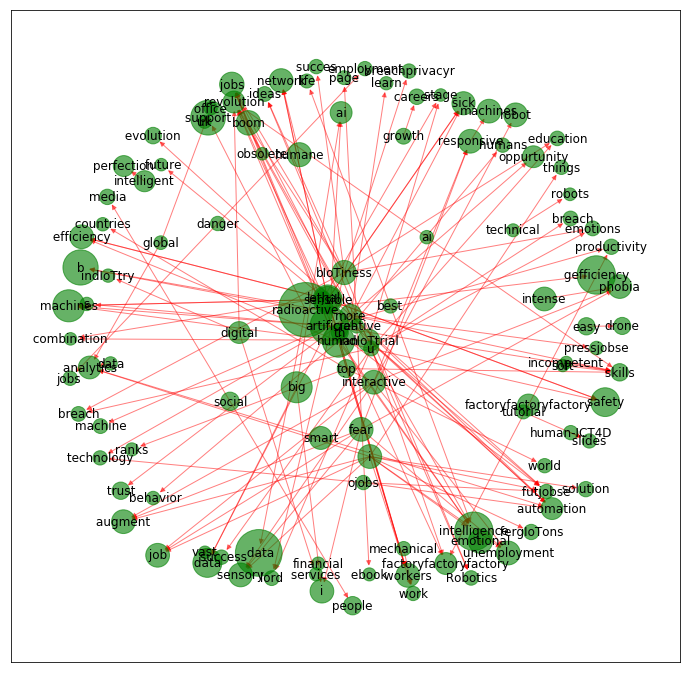

In [86]:
import matplotlib.pyplot as plt
import networkx as nx

a=pd.read_csv('new 7.csv',delimiter = ',')
n_size=[]
labels={}
for ind,item in a.iterrows():
    edges_.append((item['Adj'],item['Noun']))
    n_size.append(item['Count'])
    labels[item['Adj']]=item['Adj']
    labels[item['Noun']]=item['Noun']

    edge_=set(tuple(i) for i in edges_)
    G.add_edges_from(edge_)
#for node in G.nodes():
    #size_n.append(5)
    #n_color.append('blue')  
pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
_=nx.draw_networkx_nodes(G, pos, node_size=n_size,node_color='g',alpha = 0.6)
_=nx.draw_networkx_edges(G, pos ,alpha=0.5,edge_color='r' )
_=nx.draw_networkx_labels(G,pos,labels,font_size=12)  
